# Clusterização com a Rede Imunológica Artificial - AiNet

## 1. Introdução

A clusterização é uma tarefa de aprendizado de máquina não supervisionado que visa agrupar um conjunto de dados no mesmo grupo (chamado de cluster).

Neste notebook, exploraremos o **AiNet (Artificial Immune Network)**. O AiNet utiliza conceitos como afinidade de anticorpos e supressão de clones para identificar os centros dos clusters nos dados.

**Objetivo:** O objetivo é demonstrar a eficácia do AiNet na clusterização dos conjuntos de dados random:
* **Blobs:** Clusters bem definidos e esféricos.
* **Moons:** Clusters com uma forma não linear.
* **Circles** Clusters dispostos em dois círculos concêntricos, apresentando separação não linear. 

**Estrutura do Notebook:**
-  **Configuração:** Instalação e importação das bibliotecas necessárias.
-  **Função de Visualização:** Definição de uma função para plotar os resultados.
-  **Demonstração 1 - Dataset Blobs:** Aplicação do AiNet ao blobs.
-  **Demonstração 2 - Dataset Moons:** Aplicação do AiNet ao moons.
-  **Demonstração 3 - Dataset Circles:** Aplicação do AiNet ao circles.

## 2. Configuração


### Instalação das bibliotecas necessários.

### Importação das bibliotecas necessárias

In [15]:
# Importando a Rede Imunológica Artificial (AiNet)
from aisp.imnet import AiNet

# Bibliotecas para manipulação de dados e cálculos numéricos
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Geração de conjuntos de dados sintéticos para clusterização
from sklearn.datasets import make_blobs, make_moons, make_circles

# Visualização de dados
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx

# Funções para cálculo de árvores geradoras mínimas e distâncias
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import squareform, pdist

## 3. Função de Visualização:

In [16]:
def plot_immune_network(train_x, predict_y, model, title_prefix=""):
    """
    Plota os resultados da clusterização da AiNet.

    Paramentos:
        train_x (np.array): Os dados de entrada.
        predict_y (np.array): As previsões de cluster do modelo.
        model (AiNet): O modelo AiNet treinado.
        title_prefix (str, optional): Um prefixo para os títulos dos gráficos.
    """
    clusters = list(model._memory_network.values())
    network = np.array(model._population_antibodies)
    
    _, axs = plt.subplots(2, 2, figsize=(12, 12))
    colors = colormaps.get_cmap('Accent')

    # Dados originais
    axs[0][0].scatter(train_x[:, 0], train_x[:, 1], color='dodgerblue', alpha=0.9, s=50, marker='o', edgecolors='k')
    axs[0][0].set_title(f'{title_prefix}Dados Originais', fontsize=16)
    axs[0][0].set_xlabel('X', fontsize=14)
    axs[0][0].set_ylabel('Y', fontsize=14)
    axs[0][0].grid(True, linestyle='--', alpha=0.5)

    # População de anticorpos
    axs[0][1].scatter(network[:, 0], network[:, 1], color='crimson', alpha=0.9, s=70, marker='.', edgecolors='k')
    axs[0][1].set_title(f'{title_prefix}População de Anticorpos', fontsize=16)
    axs[0][1].set_xlabel('X', fontsize=14)
    axs[0][1].set_ylabel('Y', fontsize=14)
    axs[0][1].grid(True, linestyle='--', alpha=0.5)

    # Previsões dos clusters
    scatter = axs[1][0].scatter(train_x[:, 0], train_x[:, 1], c=predict_y, cmap='Accent', s=50, edgecolors='k', alpha=0.9)
    axs[1][0].set_title(f'{title_prefix}Previsões dos Clusters (AiNet)', fontsize=16)
    axs[1][0].set_xlabel('X', fontsize=14)
    axs[1][0].set_ylabel('Y', fontsize=14)
    axs[1][0].grid(True, linestyle='--', alpha=0.5)
    legend1 = axs[1][0].legend(*scatter.legend_elements(), title="Clusters")
    axs[1][0].add_artist(legend1)

    # Grafo da Rede Imune
    G = nx.Graph()
    positions = {}
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        G.add_nodes_from(cluster_nodes)
        for node, point in zip(cluster_nodes, cluster):
            positions[node] = tuple(point)
        dist_matrix = squareform(pdist(cluster))
        mst_local = minimum_spanning_tree(dist_matrix).toarray()
        for row_idx, row in enumerate(mst_local):
            for col_idx, weight in enumerate(row):
                if weight > 0:
                    G.add_edge(cluster_nodes[row_idx], cluster_nodes[col_idx], weight=weight)
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        nx.draw_networkx_nodes(G, positions, nodelist=cluster_nodes, ax=axs[1][1],
                               node_color=[colors(i)], node_size=70, edgecolors='k', label=f'Cluster {i}')
    nx.draw_networkx_edges(G, positions, ax=axs[1][1], alpha=0.6)
    axs[1][1].set_title(f'{title_prefix}Rede Imune Grafo', fontsize=16)
    axs[1][1].set_xlabel('X', fontsize=14)
    axs[1][1].set_ylabel('Y', fontsize=14)
    axs[1][1].grid(True, linestyle='--', alpha=0.5)
    axs[1][1].legend()
    plt.tight_layout()
    plt.show()

## 4. Demonstração 1 - Dataset Blobs

### 4.1 Gerando bolhas de dados para as classe aleatoriamente.

Utilizando a função make_blobs, são gerados dois conjuntos de dados em forma de bolhas, no intervalo entre 0 e 1, representando cada classe x e y. Em seguida, esses dados são separados em conjuntos de teste e treinamento.

In [17]:
# Gerando as amostras e saídas para o treinamento.
samples, output = make_blobs(
    n_samples=1000,
    cluster_std=0.07,
    center_box=(0.0, 1.0),
    centers=[[0.25, 0.75], [0.75, 0.25]],
    random_state=1234,
)
samples = MinMaxScaler().fit_transform(samples)

### 4.2 Treinando o modelo AiNet nos dados de bolhas

O modelo irá identificar padrões e formar clusters e classificar as amostras.

In [18]:
model = AiNet(suppression_threshold=0.96, affinity_threshold=0.95)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 126:  ┇██████████┇ 10/10 total training interactions


#### 4.3 Avalia a qualidade da clusterização com o coeficiente de silhueta

In [19]:
silhouette = silhouette_score(samples, predict_y)
print(f"Coeficiente de Silhueta: {silhouette:.3f}")

Coeficiente de Silhueta: 0.826


### 4.4 Visualizando os resultados do AiNet para os dados de bolhas

Exibe quatro gráficos: os dados originais, a população de anticorpos, os clusters previstos pelo AiNet e o grafo da rede imune formada.

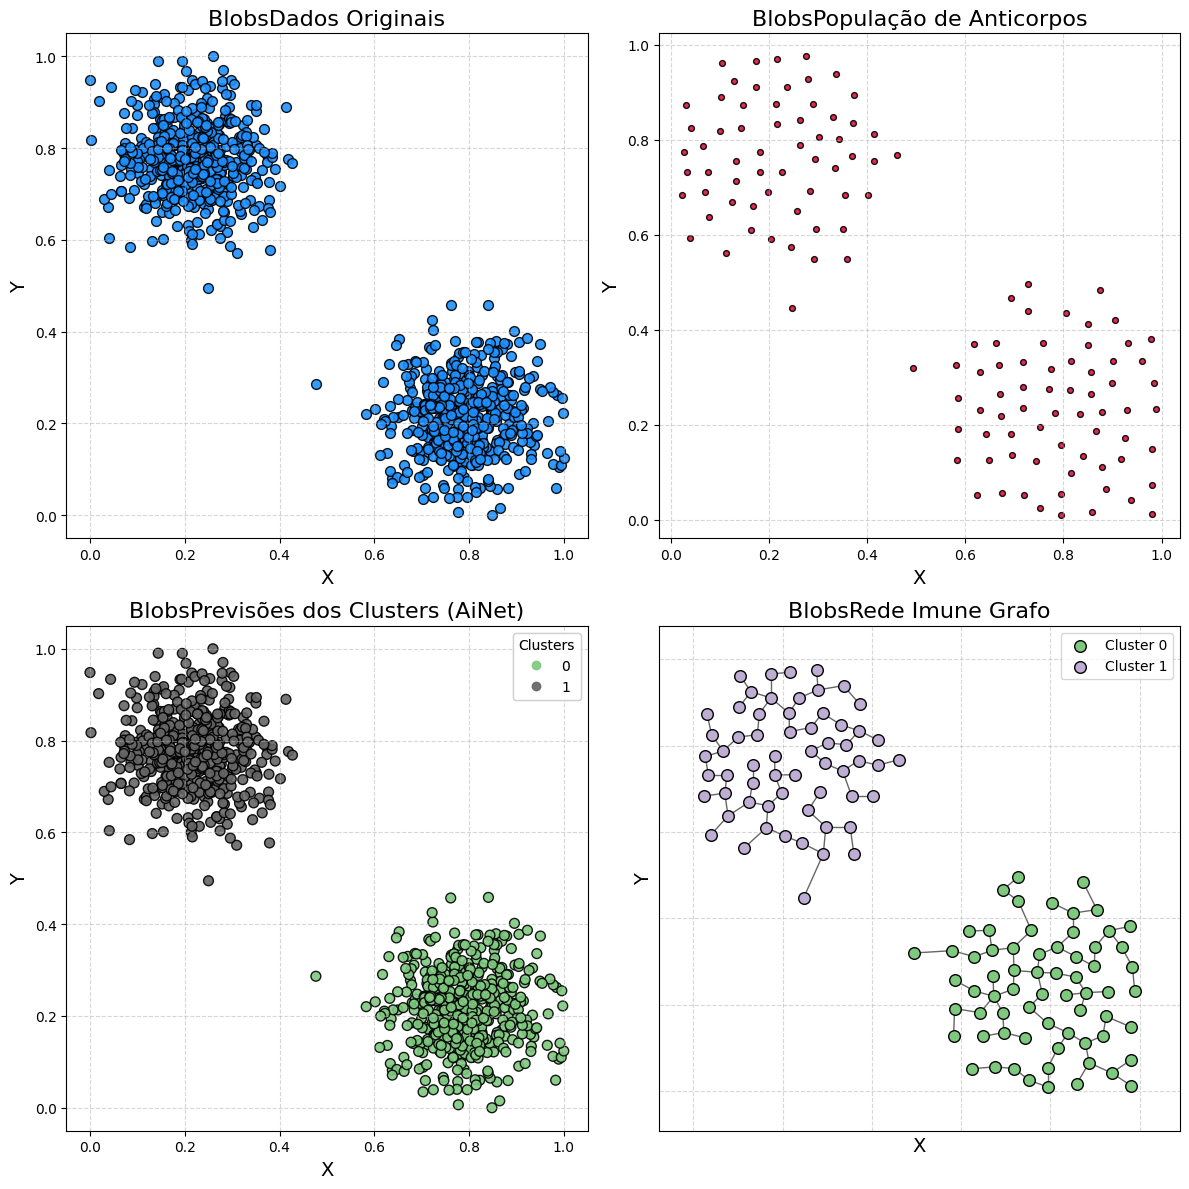

In [20]:
plot_immune_network(samples, predict_y, model, title_prefix="Blobs")

## 5. Demonstração 2 - Dataset Moons

### 5.1 Gerando dados em formato de "moons" (luas)

Gera um conjunto de dados em formato de duas luas entrelaçadas.

In [21]:
# Gerando as amostras e saídas para o treinamento.
samples, output = make_moons(n_samples=1000, noise=0.05, random_state=42)
samples = MinMaxScaler().fit_transform(samples)

### 5.2 Treinando o AiNet nos dados de "moons"
O modelo irá identificar padrões e formar clusters e classificar as amostras.

In [22]:
model = AiNet(suppression_threshold=0.95, affinity_threshold=0.97)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 73:  ┇██████████┇ 10/10 total training interactions


#### 5.3 Avalia a qualidade da clusterização com o coeficiente de silhueta

In [23]:
silhouette = silhouette_score(samples, predict_y)
print(f"Coeficiente de Silhueta: {silhouette:.3f}")

Coeficiente de Silhueta: 0.398


#### 5.4 Visualizando o AiNet nos dados de "moons"

Exibe quatro gráficos: os dados originais, a população de anticorpos, os clusters previstos pelo AiNet e o grafo da rede imune formada.

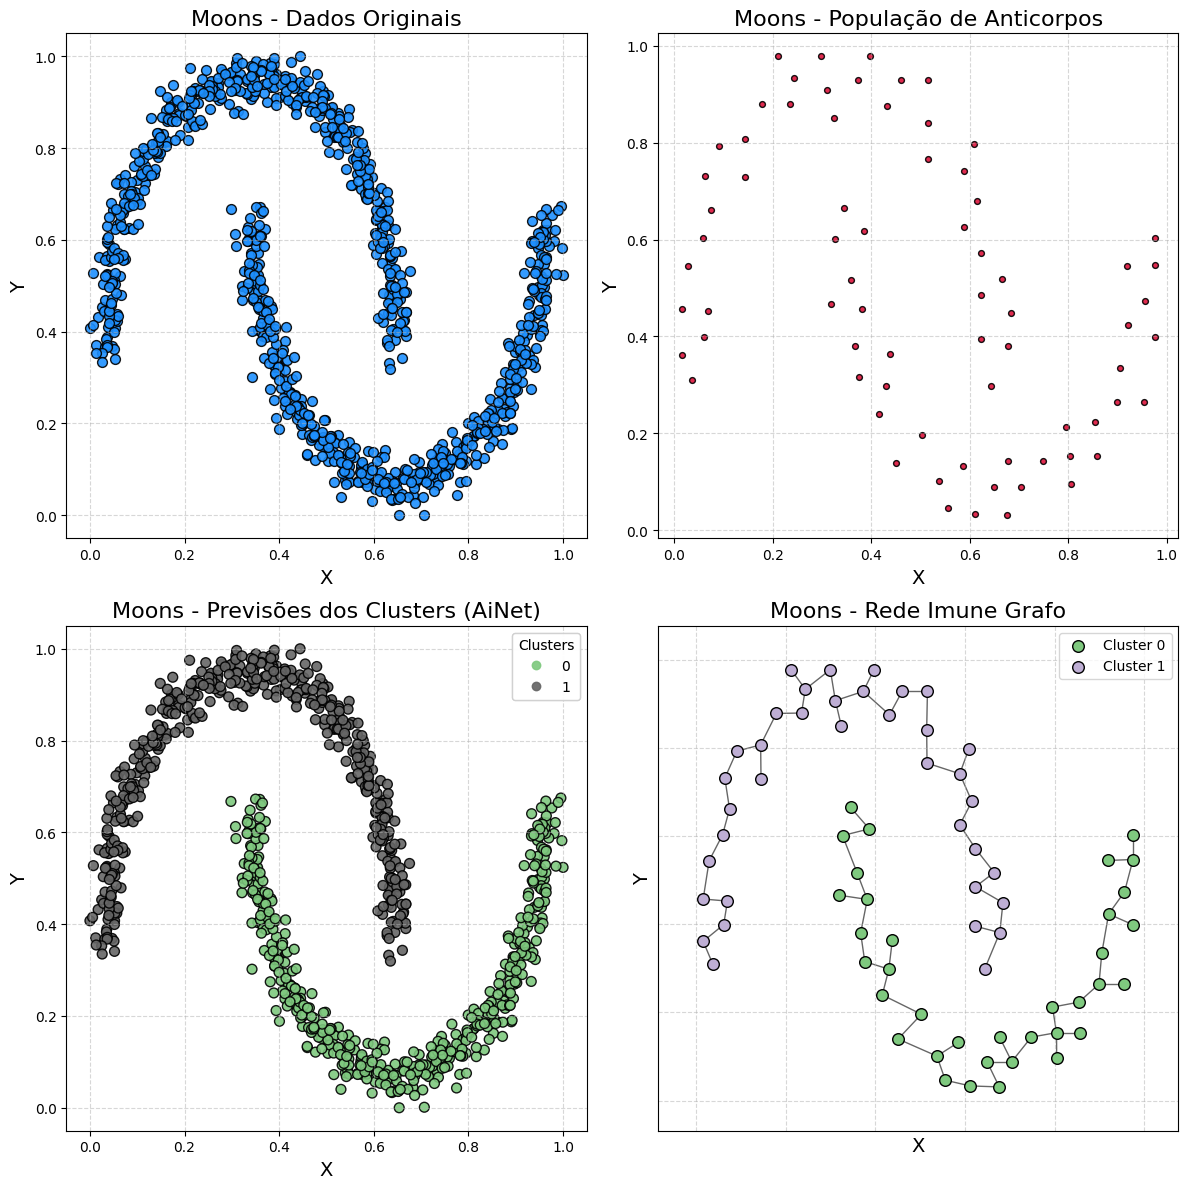

In [24]:
plot_immune_network(samples, predict_y, model, title_prefix="Moons - ")

## 6. Demonstração 3 - Dataset Circles

### 6.1 Gerando dados em formato de círculos concêntricos

Utilizando o `make_circles` para criar dados em dois círculos.

In [25]:
# Gerando as amostras e saídas para o treinamento.
samples, output = make_circles(n_samples=1000, noise=0.05, factor=0.5)
samples = MinMaxScaler().fit_transform(samples)

#### 6.2 Treinando o AiNet nos dados de "circles"
O modelo irá identificar padrões e formar clusters e classificar as amostras.

In [26]:
model = AiNet(suppression_threshold=0.97, affinity_threshold=0.98)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 162:  ┇██████████┇ 10/10 total training interactions


#### 6.3 Avalia a qualidade da clusterização com o coeficiente de silhueta

In [27]:
silhouette = silhouette_score(samples, predict_y)
print(f"Coeficiente de Silhueta: {silhouette:.3f}")

Coeficiente de Silhueta: 0.112


#### 6.4 Visualizando o AiNet nos dados de círculos

Exibe quatro gráficos: os dados originais, a população de anticorpos, os clusters previstos pelo AiNet e o grafo da rede imune formada.

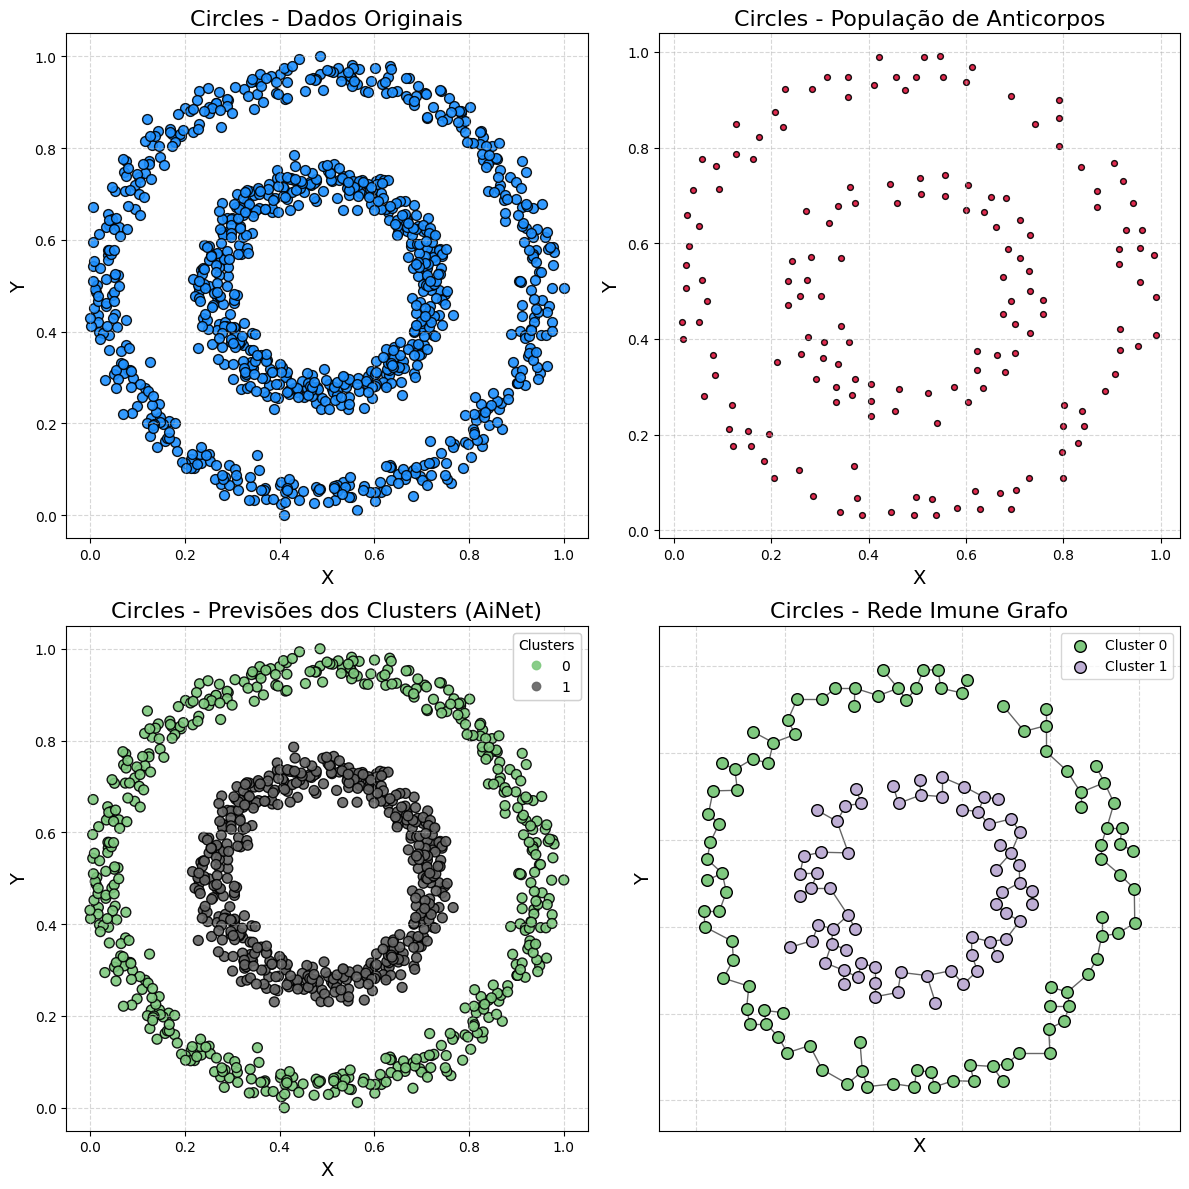

In [28]:
plot_immune_network(samples, predict_y, model, title_prefix="Circles - ")